In [1]:
import pandas as pd 
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import sklearn 
import seaborn as sns 
import os 
from tqdm import tqdm 
from glob import glob 
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.svm import SVC
from sklearn.decomposition import PCA 
from sklearn.datasets import load_digits,load_iris
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from matplotlib.colors import ListedColormap

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 데이터 로드 및 전처리 

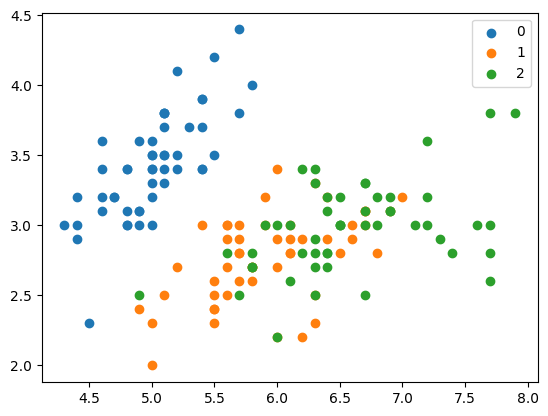

In [2]:
def data_load():
    #데이터 로드 
    data = load_iris() 
    df = pd.DataFrame(data.data)
    df.columns = data['feature_names']
    df['class'] = data['target']
    df = df.sample(frac=1,random_state=42).reset_index(drop=True) #shuffle 
    return df 

def train_split(X,Y):
    idx = int(len(X)*0.8)
    train_x = X[:idx]
    train_y = Y[:idx]
    test_x = X[idx:]
    test_y = Y[idx:]
    return train_x, train_y, test_x, test_y


def data_preprocess(df):
    class_list = ['sepal length (cm)','sepal width (cm)']
    X = df.drop(columns='class')[class_list].to_numpy()
    Y = df['class'].to_numpy()


    train_x, train_y, test_x, test_y = train_split(X,Y)
    return (X,Y),(train_x, train_y, test_x, test_y)

df = data_load() 

(X,Y),(train_x, train_y, test_x, test_y) = data_preprocess(df)


for i in np.unique(df['class']):
    plt_x = X[np.where(Y == i )[0]] 
    plt.scatter(plt_x[:,0],plt_x[:,1],label=i)
    plt.legend()
plt.show()


# 모델링 

## 커널에 따른 차이 비교 

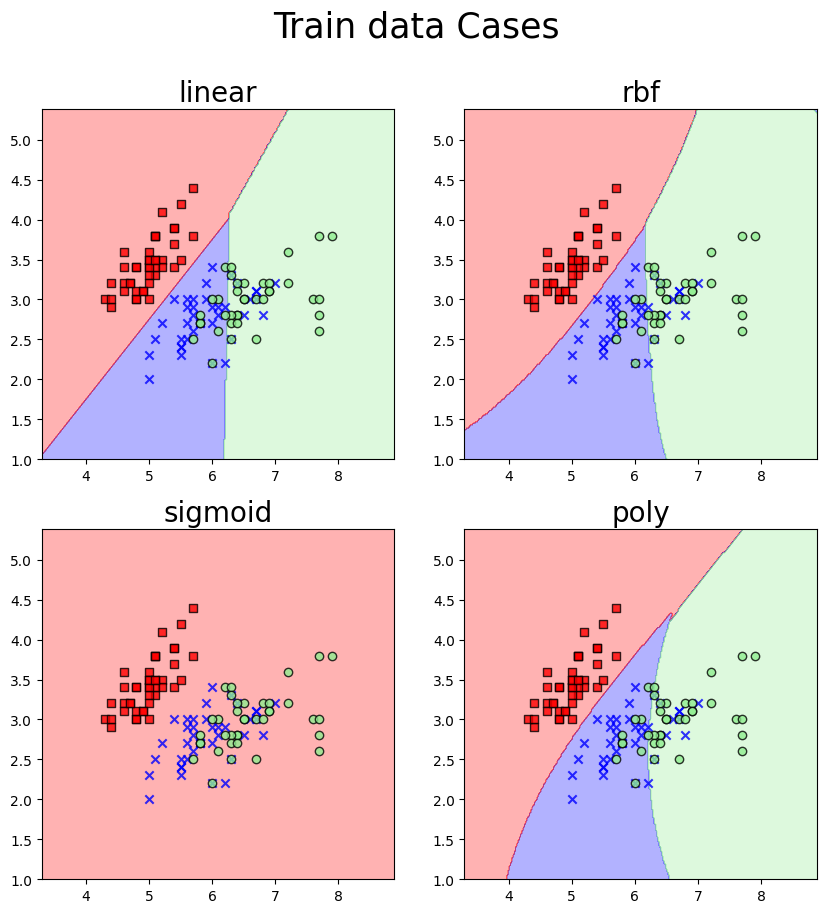

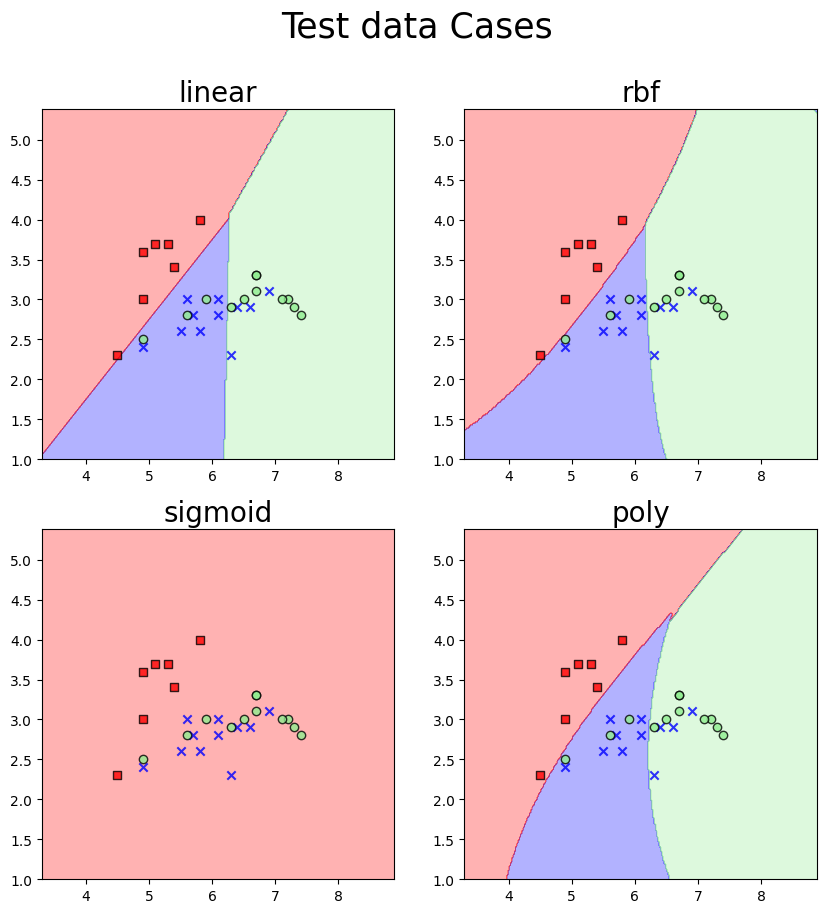

In [4]:
def make_decision_boundary(X,y,classifier,kernel,resolution=0.02):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    return xx1,xx2,Z

def plot_decion_boundary(xx1,xx2,z,ax,X,y,kernel):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_title(f'{kernel}',fontsize=20)
    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')

def model_metric(model,test_x,test_y):
    y_pred = model.predict(test_x)
    f1 = f1_score(test_y,y_pred,average='macro')
    precision = precision_score(test_y,y_pred,average='macro')
    recall  = recall_score(test_y,y_pred,average='macro')
    acc = accuracy_score(test_y,y_pred)
    return [acc,precision,recall,f1]

def model_train(kernel,data):
    (train_x, train_y, test_x, test_y) = data 

    model = SVC(C=1,kernel=kernel)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    return model 


(X,Y),data = data_preprocess(df)


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(10, 10))
fig.suptitle('Train data Cases',fontsize=25)

train_metric_list = [] 
for kernel,ax in zip(['linear','rbf','sigmoid','poly'],[ax1,ax2,ax3,ax4]):
    model = model_train(kernel,data)
    train_metric_list.append(model_metric(model,train_x,train_y))
    xx1,xx2,Z = make_decision_boundary(train_x,train_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,train_x,train_y,kernel)  
    
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(10, 10))
fig.suptitle('Test data Cases',fontsize=25)

test_metric_list = [] 
for kernel,ax in zip(['linear','rbf','sigmoid','poly'],[ax1,ax2,ax3,ax4]):
    model = model_train(kernel,data)
    test_metric_list.append(model_metric(model,test_x,test_y))
    xx1,xx2,Z = make_decision_boundary(train_x,train_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,test_x,test_y,kernel)
    

In [60]:
pd.DataFrame(train_metric_list)

,0,1,2,3
0,0.833333,0.826811,0.826811,0.826811
1,0.833333,0.827252,0.827036,0.826811
2,0.358333,0.119444,0.333333,0.175869
3,0.825000,0.818243,0.818039,0.818059


In [61]:
pd.DataFrame(test_metric_list)

,0,1,2,3
0,0.766667,0.797436,0.795455,0.795556
1,0.766667,0.797436,0.795455,0.795556
2,0.233333,0.077778,0.333333,0.126126
3,0.766667,0.797436,0.795455,0.795556


## C : Margin 에 따른 비교 

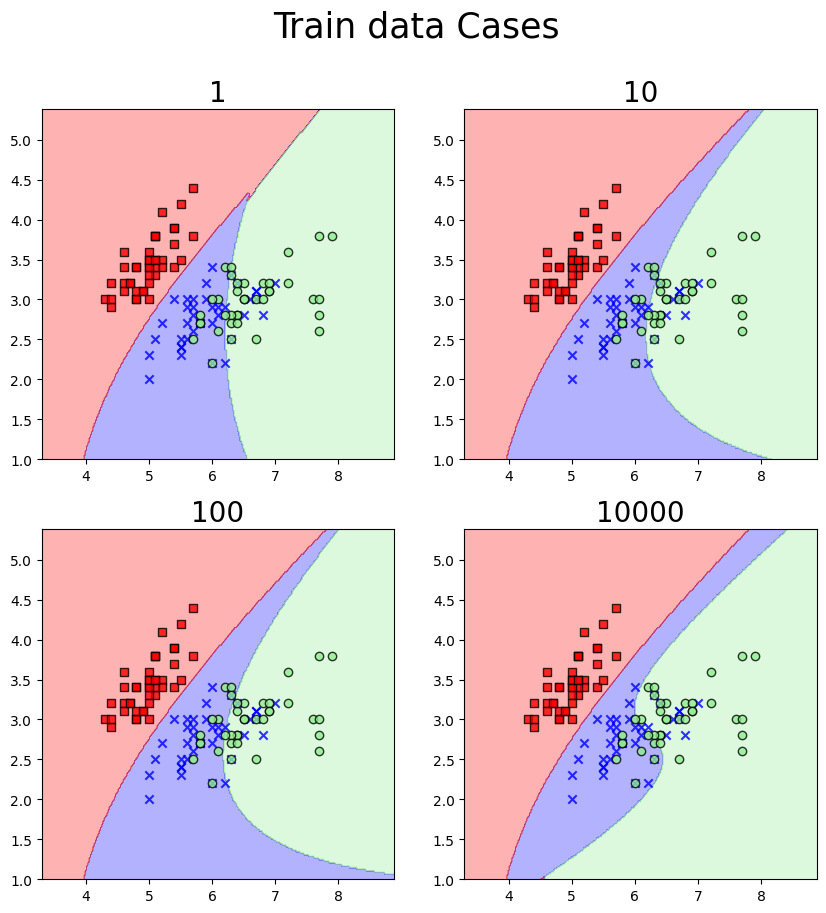

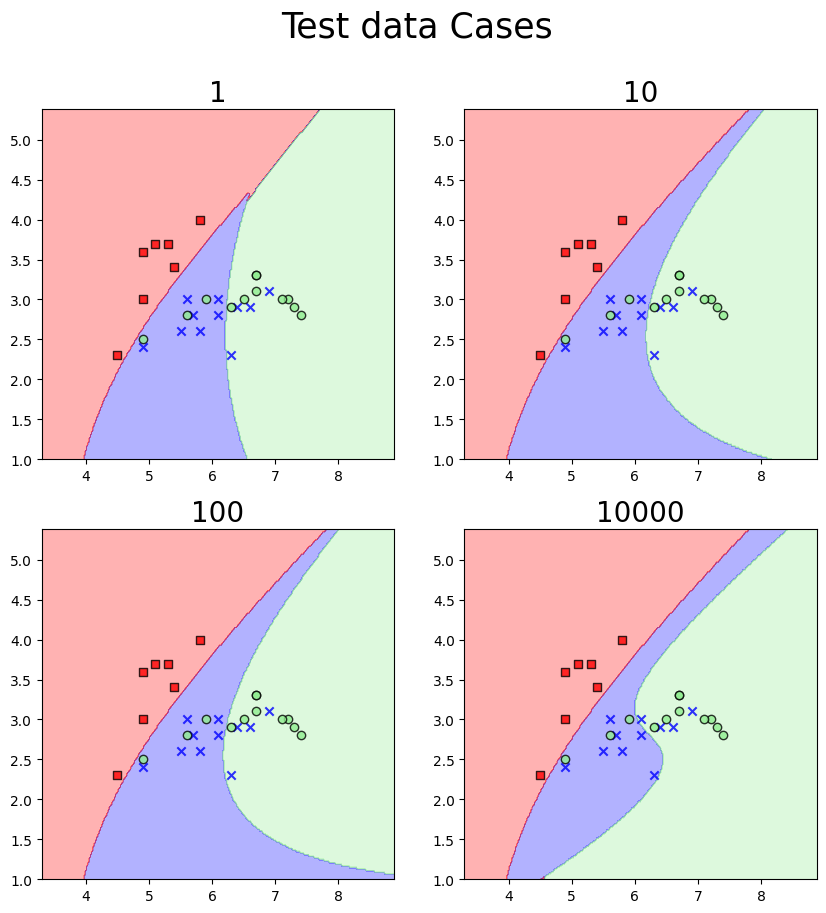

In [13]:
def C_model_train(data,C):
    (train_x, train_y, test_x, test_y) = data 

    model = SVC(C=C,kernel='poly')
    model.fit(train_x,train_y)
    return model 


(X,Y),data = data_preprocess(df)


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(10, 10))
fig.suptitle('Train data Cases',fontsize=25)

train_metric_list = [] 
for C,ax in zip([1,10,100,10000],[ax1,ax2,ax3,ax4]):
    model = C_model_train(data,C)
    train_metric_list.append(model_metric(model,train_x,train_y))
    xx1,xx2,Z = make_decision_boundary(train_x,train_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,train_x,train_y,C)  
    
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(10, 10))
fig.suptitle('Test data Cases',fontsize=25)

test_metric_list = [] 
for C,ax in zip([1,10,100,10000],[ax1,ax2,ax3,ax4]):
    model = C_model_train(data,C)
    test_metric_list.append(model_metric(model,test_x,test_y))
    xx1,xx2,Z = make_decision_boundary(train_x,train_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,test_x,test_y,C)  
    

In [14]:
pd.DataFrame(train_metric_list)

,0,1,2,3
0,0.825000,0.818243,0.818039,0.818059
1,0.825000,0.819048,0.817814,0.817690
2,0.825000,0.819048,0.817814,0.817690
3,0.833333,0.826811,0.826811,0.826811


In [15]:
pd.DataFrame(test_metric_list)

,0,1,2,3
0,0.766667,0.797436,0.795455,0.795556
1,0.766667,0.797436,0.795455,0.795556
2,0.766667,0.797436,0.795455,0.795556
3,0.766667,0.797436,0.795455,0.795556


# 다른 모델과 비교 

In [ ]:
import torch 
import torch.nn as nn 

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Sequential(
                                    nn.Linear(2,10),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(10)
                                    )
        self.fc1_1 = nn.Sequential(  
                                    nn.Linear(10,10),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(10))                                
        self.fc2 = nn.Linear(10,3)
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc1_1(x)
        x = self.fc1_1(x)
        x = self.fc2(x)
        return x 
    
def NN_metric(NN,data_x,data_y):
    data_x,data_y= torch.tensor(data_x).to(device).type(torch.float), torch.tensor(data_y).to(device).type(torch.float)
    y_pred = NN(data_x)
    y_pred = torch.argmax(y_pred,axis=1).detach().cpu().numpy()

    f1 = f1_score(data_y.detach().cpu().numpy(),y_pred,average='macro')
    acc = accuracy_score(data_y.detach().cpu().numpy(),y_pred)
    recall = recall_score(data_y.detach().cpu().numpy(),y_pred,average='macro')
    precision = precision_score(data_y.detach().cpu().numpy(),y_pred,average='macro')
    return [acc,precision,recall,f1]
    
    
def nn_plot_decision_boundary(X,y,classifier,kernel,ax,resolution=0.2):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #결정경계
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    input_x = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = NN(torch.tensor(input_x).type(torch.float).to(device))
    y_pred = torch.argmax(Z,axis=1)
    Z = y_pred.detach().cpu().numpy().reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title('Neural Network')
    
    #샘플의 산점도 
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    plt.show()
fig,ax = plt.subplots(2,1)


device = 'cuda:0'
NN = Model().to(device)
optimizer = torch.optim.Adam(NN.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 20000

train_x, train_y = torch.tensor(train_x).type(torch.float).to(device),torch.tensor(train_y).type(torch.float).to(device)

for epoch in range(num_epochs):
    NN.train()
    optimizer.zero_grad()
    y_pred = NN(train_x)
    loss = criterion(y_pred,train_y.reshape(-1).type(torch.long))
    loss.backward()
    optimizer.step()
    
    print(loss)
    
y_pred = torch.argmax(NN(torch.tensor(test_x).to(device).type(torch.float)),axis=1).detach().cpu().numpy()    

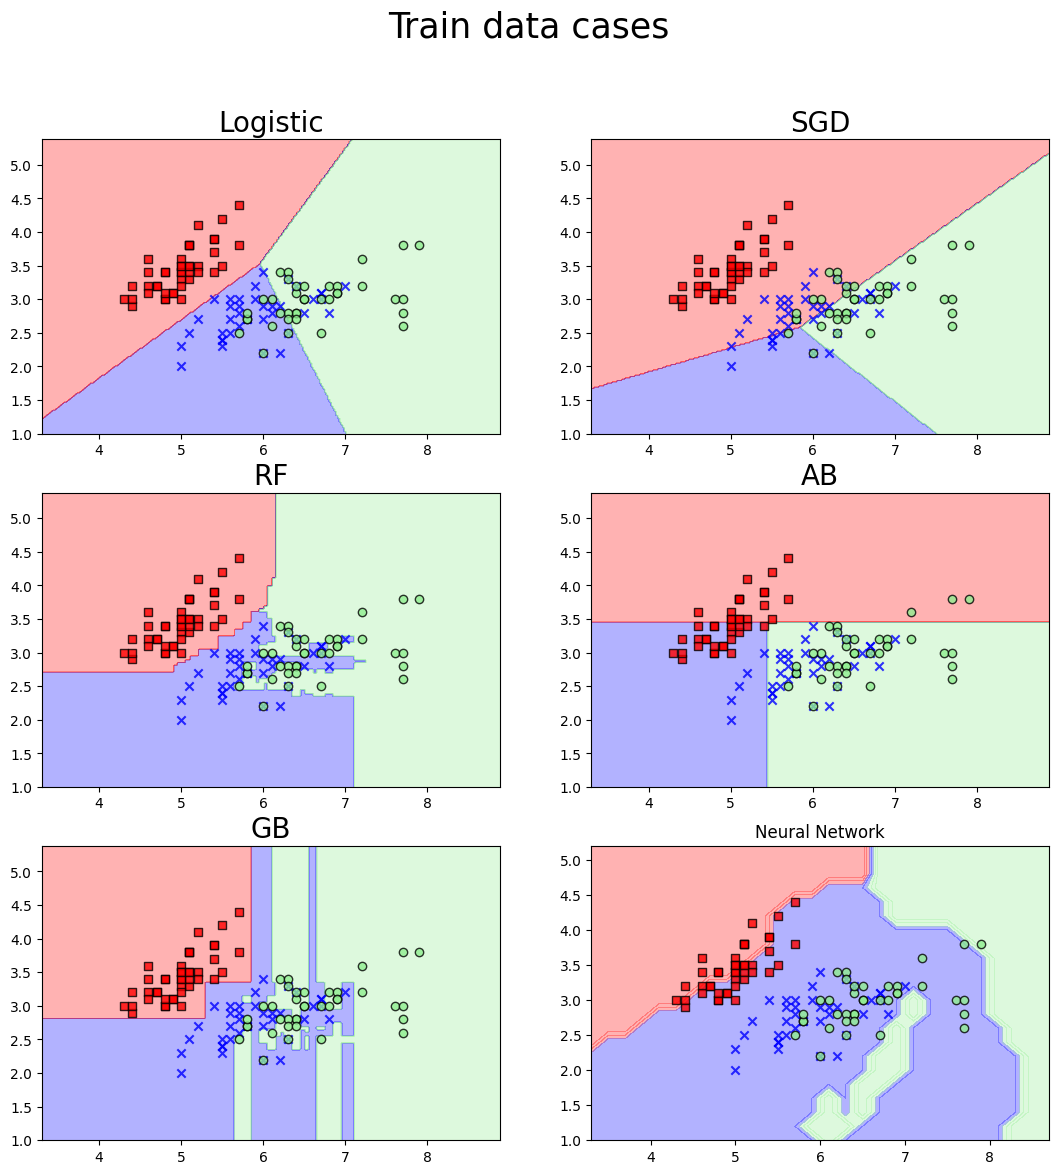

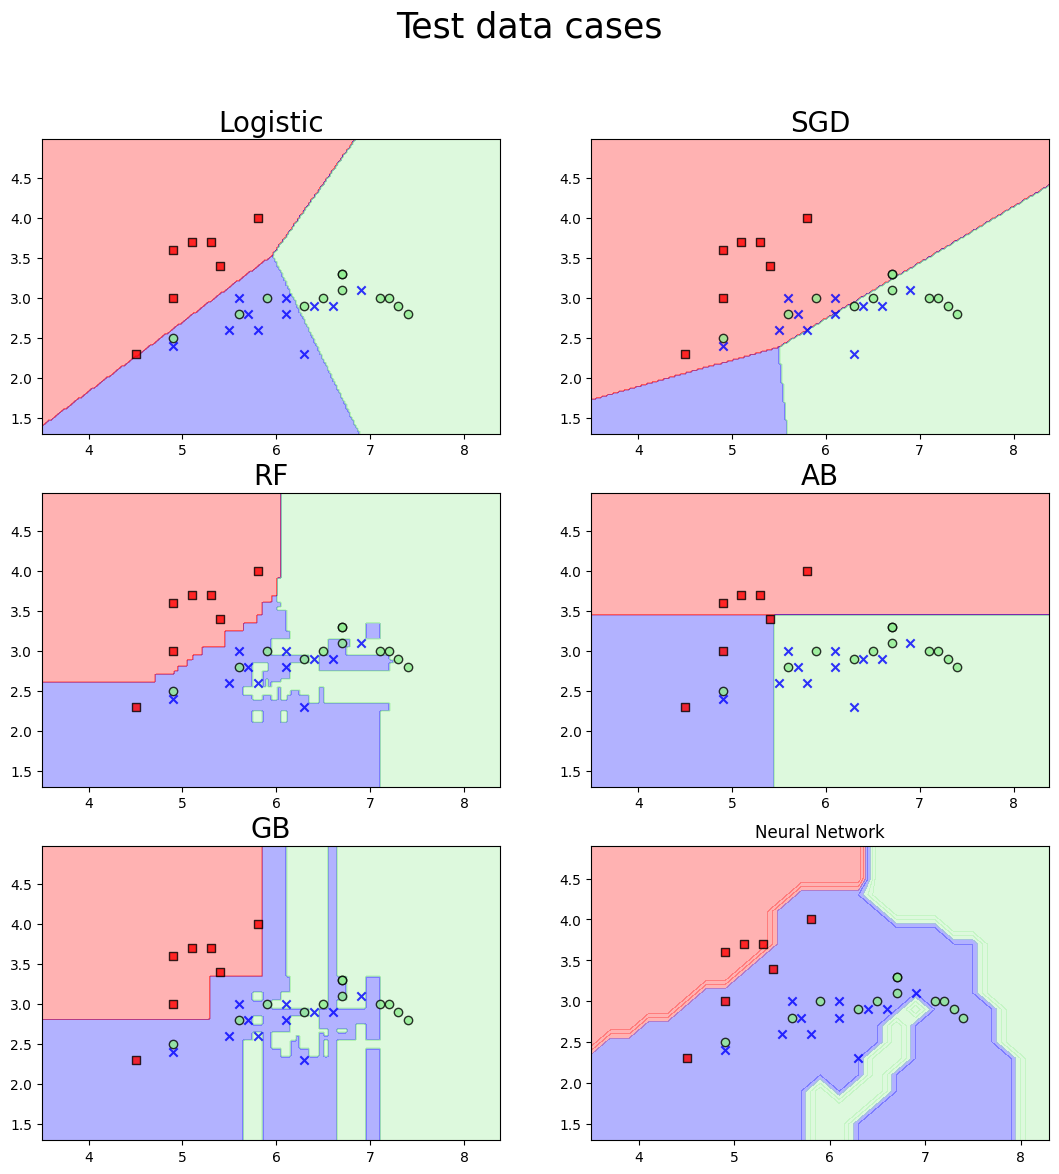

In [34]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

(X,Y),data = data_preprocess(df)
(train_x, train_y, test_x, test_y) = data 
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(ncols=2,nrows=3,figsize=(13, 13))
fig.suptitle('Train data cases',fontsize=25)

train_metric_list = [] 

for model_func,model_name,ax in zip([LogisticRegression,SGDClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier],['Logistic','SGD','RF','AB','GB'],[ax1,ax2,ax3,ax4,ax5]):
    model = model_func()
    model.fit(train_x,train_y)
    y_pred = model.predict(train_x)
    train_metric_list.append(model_metric(model,train_x,train_y))
    xx1,xx2,Z = make_decision_boundary(train_x,train_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,train_x,train_y,kernel=model_name)
    
nn_plot_decision_boundary(train_x,train_y,NN,ax6,'nn') 
train_metric_list.append(NN_metric(NN,train_x,train_y))



fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(ncols=2,nrows=3,figsize=(13, 13))
fig.suptitle('Test data cases',fontsize=25)
test_metric_list = [] 

for model_func,model_name,ax in zip([LogisticRegression,SGDClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier],['Logistic','SGD','RF','AB','GB'],[ax1,ax2,ax3,ax4,ax5]):
    model = model_func()
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    test_metric_list.append(model_metric(model,test_x,test_y))
    xx1,xx2,Z = make_decision_boundary(test_x,test_y,model,kernel)
    plot_decion_boundary(xx1,xx2,Z,ax,test_x,test_y,kernel=model_name)
    
nn_plot_decision_boundary(test_x,test_y,NN,ax6,'nn') 
test_metric_list.append(NN_metric(NN,test_x,test_y))
        

In [64]:
pd.DataFrame(train_metric_list)

,0,1,2,3
0,0.833333,0.827236,0.826586,0.826577
1,0.675000,0.497835,0.666667,0.553623
2,0.941667,0.939640,0.939271,0.939353
3,0.483333,0.510352,0.489287,0.453878
4,0.941667,0.939496,0.939496,0.939394
5,0.925000,0.923442,0.922402,0.922025


In [65]:
pd.DataFrame(train_metric_list)

,0,1,2,3
0,0.833333,0.827236,0.826586,0.826577
1,0.675000,0.497835,0.666667,0.553623
2,0.941667,0.939640,0.939271,0.939353
3,0.483333,0.510352,0.489287,0.453878
4,0.941667,0.939496,0.939496,0.939394
5,0.925000,0.923442,0.922402,0.922025


In [9]:
def data_load():
    #데이터 로드 
    data = load_iris() 
    df = pd.DataFrame(data.data)
    df.columns = data['feature_names']
    df['class'] = data['target']
    df = df.sample(frac=1,random_state=42).reset_index(drop=True) #shuffle 
    return df 

In [14]:
df = data_load()
X = df.drop(columns = 'class').to_numpy()

In [16]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2,kernel='rbf')
kpca.fit_transform(X)

(150, 2)